<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 3: Web APIs & NLP
### Reddit Scams: Are We Vulnerable?
---

## 2. Data Cleaning

### 2.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 2.2 Import scraped dataset

In [2]:
df = pd.read_csv('cleaned_data_new.csv')
df.head()

,age,height,weight,bmi,yrssmok,packday,yrsquit,sleep_hours,health_status,phys_health_not_good,...,chd_mi,asthma_status,race_ethnicity,sex,education,income,smoker_status,e_cig_smoker,binge_drinker,heavy_drinker
0,80.0,NaN,NaN,NaN,0.0,0.0,0.0,8.0,Very Good,0 days,...,No,Never,White,Female,Grad College or Tech Sch,NaN,Never smoked,No,No,No
1,80.0,1.60,68.04,26.58,0.0,0.0,0.0,6.0,Excellent,0 days,...,No,Never,White,Female,Grad High Sch,$25k-$35k,Never smoked,No,No,No
2,56.0,1.57,63.50,25.76,0.0,0.0,0.0,5.0,Very Good,1-13 days,...,No,Never,White,Female,Grad College or Tech Sch,$100k-$200k,Never smoked,No,No,No
3,73.0,1.65,63.50,23.32,0.0,0.0,0.0,7.0,Excellent,0 days,...,No,Current,White,Female,Grad High Sch,NaN,Current smoker - some days,No,No,No
4,43.0,1.57,53.98,21.90,0.0,0.0,0.0,9.0,Fair,1-13 days,...,No,Never,White,Female,Attended College or Tech Sch,$25k-$35k,Never smoked,No,No,No


### 2.3 First look at data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46999 entries, 0 to 46998
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        46999 non-null  float64
 1   height                     43756 non-null  float64
 2   weight                     42778 non-null  float64
 3   bmi                        42134 non-null  float64
 4   yrssmok                    43181 non-null  float64
 5   packday                    43163 non-null  float64
 6   yrsquit                    42900 non-null  float64
 7   sleep_hours                46411 non-null  float64
 8   health_status              46851 non-null  object 
 9   phys_health_not_good       45526 non-null  object 
 10  mental_health_not_good     45761 non-null  object 
 11  last_routine_checkup       46286 non-null  object 
 12  visit_dentist_past_year    45024 non-null  object 
 13  health_insurance           44985 non-null  obj

### 2.7 Check for null values

In [4]:
df.isnull().sum()

age                              0
height                        3243
weight                        4221
bmi                           4865
yrssmok                       3818
packday                       3836
yrsquit                       4099
sleep_hours                    588
health_status                  148
phys_health_not_good          1473
mental_health_not_good        1238
last_routine_checkup           713
visit_dentist_past_year       1975
health_insurance              2014
phy_exercise_past_30_days      141
stroke                         226
cancer                         320
kidney_disease                 251
colon_sigmoidoscopy           2459
chd_mi                         605
asthma_status                  525
race_ethnicity                1851
sex                              1
education                      333
income                       10185
smoker_status                 4104
e_cig_smoker                  4148
binge_drinker                 5983
heavy_drinker       

### 2.8 Initial Modelling (Baseline Scores only)

#### 2.8.0 LazyPredict to get Baseline scores

In [5]:
pip install lazypredict

##### 2.8.0.1 Classifier Models

In [6]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the name of the target column

X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# models is a DataFrame that contains the performance metrics for each model
print(models)

100%|██████████| 29/29 [00:05<00:00,  5.48it/s]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


##### 2.8.0.2 Regressor Models

In [7]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the name of the target column for regression

X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# models is a DataFrame that contains the performance metrics for each model
print(models)

100%|██████████| 42/42 [00:08<00:00,  5.21it/s]

Empty DataFrame
Columns: [Adjusted R-Squared, R-Squared, RMSE, Time Taken]
Index: []


#### 2.8.1 XGBoost

We noticed that there were many comments/ replies that were auto-generated by bot. These do not serve much meaning to our analysis, hence we will remove these rows.

In [8]:
pip install xgboost

In [9]:
# Drop rows where the target variable 'cvdcrhd4' is nan
df = df.dropna(subset=['chd_mi'])
# If you decide to remap, here is how you could do it for binary classification
mapping = {'No': 0, 'Yes': 1}
df['chd_mi'] = df['chd_mi'].map(mapping)

In [10]:
# The column name in the dropna() method should match the column you're intending to use
df = df.dropna(subset=['chd_mi'])  # Make sure 'chd_mi' is the correct column name

In [11]:
# Separate features and target
X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

# Ensure y is of integer type
y = y.astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Convert object dtypes to category
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

In [13]:
# Initialize the XGBoost classifier with enable_categorical=True
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 90.66%


In [14]:
# Train score
train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Test score
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5)

# Print the average of the cross-validation scores
print(f"CV Mean Score: {cv_scores.mean() * 100:.2f}%")

# Optionally, you can also look at the individual folds' scores
print(f"CV Scores per Fold: {[f'{score * 100:.2f}%' for score in cv_scores]}")

Train Accuracy: 94.62%
Test Accuracy: 90.66%
CV Mean Score: 90.67%
CV Scores per Fold: ['90.72%', '90.45%', '90.00%', '91.18%', '91.01%']


#### 2.8.2 Random Forest

In [15]:
pip install scikit-learn

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Separate features and target
X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

# Impute missing values in features
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

X_encoded = pd.get_dummies(X_imputed)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
# Predictions for evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train and Test accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Perform 5-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_encoded, y, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"CV Mean Score: {cv_mean * 100:.2f}%")
print(f"CV Standard Deviation: {cv_std * 100:.2f}%")

Train Accuracy: 99.99%
Test Accuracy: 91.01%
CV Mean Score: 91.04%
CV Standard Deviation: 0.03%


#### 2.8.3 Decision Tree

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

# Correctly create a preprocessing pipeline for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Add OneHotEncoder for categorical data
])

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)


In [19]:
# Proceed with training and evaluating the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

cv_scores = cross_val_score(model, X_preprocessed, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"CV Mean Score: {cv_mean * 100:.2f}%")
print(f"CV Standard Deviation: {cv_std * 100:.2f}%")


Train Accuracy: 98.30%
Test Accuracy: 85.12%
CV Mean Score: 84.87%
CV Standard Deviation: 1.07%


### 2.10 Modelling (with parameters)

We will only run the models on df2. The reason being - when we dropped values, there were 0 rows for df1 - hence there is no point running model on an empty dataframe.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#### Instantiating Pipeline

In [21]:
# Logistic Regression Pipeline
logistic_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# SVM Pipeline
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # No scaler needed for tree-based models
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # No scaler needed for tree-based models
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

#### Parameter Grids

In [22]:
logistic_param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['saga'],
    'model__max_iter': [100, 1000, 5000]
}

In [23]:
svm_param_grid = {
    'model__C': [1, 10],  # Reduced range of C values
    'model__gamma': ['scale', 0.01],  # Limited gamma to 'scale' and a representative value
    'model__kernel': ['rbf'],  # Focus on the RBF kernel, often the best choice for SVM
    # Removed 'model__degree': Typically, 'poly' kernel requires more processing time
}


In [24]:
xgb_param_grid = {
    'model__max_depth': [5, 7],  # Focused on mid-range depths
    'model__n_estimators': [100, 200],  # Reduced the upper range
    'model__learning_rate': [0.1],  # Chose a commonly effective rate
    'model__subsample': [0.7, 1.0],  # Limited to higher subsampling for variance reduction
    'model__colsample_bytree': [0.7],  # Chose a moderate value for feature sampling
    'model__gamma': [0, 0.1]  # Simplified to two options to evaluate regularization benefit
}


In [25]:
rf_param_grid = {
    'model__n_estimators': [100, 200],  # Reduced number of trees options
    'model__max_depth': [10, 20],  # Focus on moderate to high depth to control complexity
    'model__min_samples_split': [2, 5],  # Simplified range for minimum number of samples required to split
    'model__min_samples_leaf': [1, 2],  # Reduced range for the minimum number of samples required at a leaf node
    'model__max_features': ['auto'],  # Use the default option for the number of features to consider when looking for the best split
    'model__bootstrap': [True]  # Keep bootstrapping enabled for better generalization
    # Removed 'model__criterion': Simplification, sticking with the default 'gini' criterion
}


#### GridSearchCV Execution

In [26]:
# Logistic Regression GridSearchCV
logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train, y_train)

# Best parameters and CV score
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best CV score for Logistic Regression:", logistic_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = logistic_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for Logistic Regression:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = logistic_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for Logistic Regression:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index1 = logistic_grid_search.best_index_
mean_cv_score = logistic_grid_search.cv_results_['mean_test_score'][best_index1]
std_cv_score = logistic_grid_search.cv_results_['std_test_score'][best_index1]
print(f"Mean CV score for the best Logistic Regression model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for Logistic Regression: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best CV score for Logistic Regression: 0.9098208271588307
Train accuracy for Logistic Regression: 0.9098208271588306
Test accuracy for Logistic Regression: 0.9099040844918633
Mean CV score for the best Logistic Regression model: 0.9098 ± 0.0001


In [27]:
# SVM GridSearchCV
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best score for SVM:", svm_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = svm_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for SVM", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = svm_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for SVM:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = svm_grid_search.best_index_
mean_cv_score = svm_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = svm_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best SVM model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for SVM: {'model__C': 1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Best score for SVM: 0.9099016570119899
Train accuracy for SVM 0.9099555435807625
Test accuracy for SVM: 0.9099040844918633
Mean CV score for the best SVM model: 0.9099 ± 0.0001


In [28]:
# XGBoost GridSearchCV
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", xgb_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = xgb_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for XGBoost:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = xgb_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for XGBoost:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = xgb_grid_search.best_index_
mean_cv_score = xgb_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = xgb_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best XGBoost model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for XGBoost: {'model__colsample_bytree': 0.7, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best score for XGBoost: 0.9096052808837397
Train accuracy for XGBoost: 0.9106291256904216
Test accuracy for XGBoost: 0.9100118547257248
Mean CV score for the best XGBoost model: 0.9096 ± 0.0005


In [29]:
# Random Forest GridSearchCV
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best score for Random Forest:", rf_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = rf_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for Random Forest:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = rf_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for Random Forest:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = rf_grid_search.best_index_
mean_cv_score = rf_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = rf_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best Random Forest model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for Random Forest: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score for Random Forest: 0.9098208271588307
Train accuracy for Random Forest: 0.9104944092684898
Test accuracy for Random Forest: 0.9099040844918633
Mean CV score for the best Random Forest model: 0.9098 ± 0.0001


##### Determining the Confusion Matrix (using LogReg & SVM)

Rationale: Since they have the closest Train and Test score

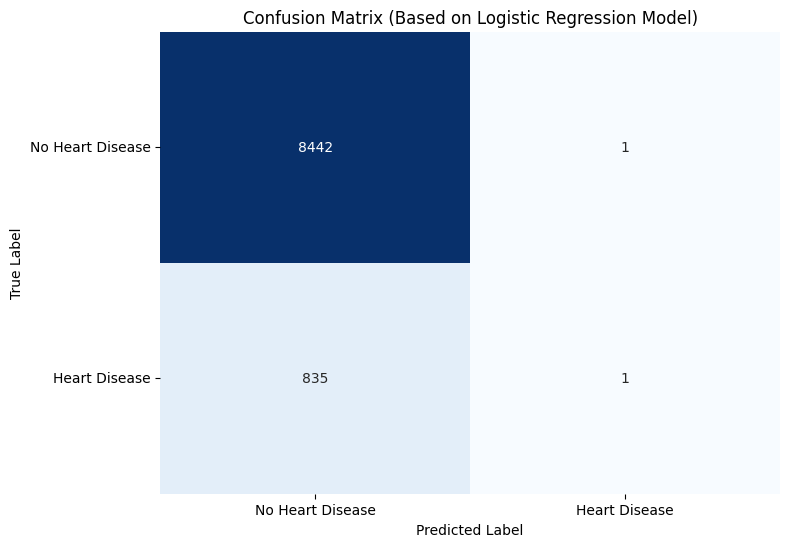

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the target values based on the best estimator found by GridSearchCV
y_test_pred = logistic_grid_search.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Based on Logistic Regression Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'], rotation=0)
plt.show()

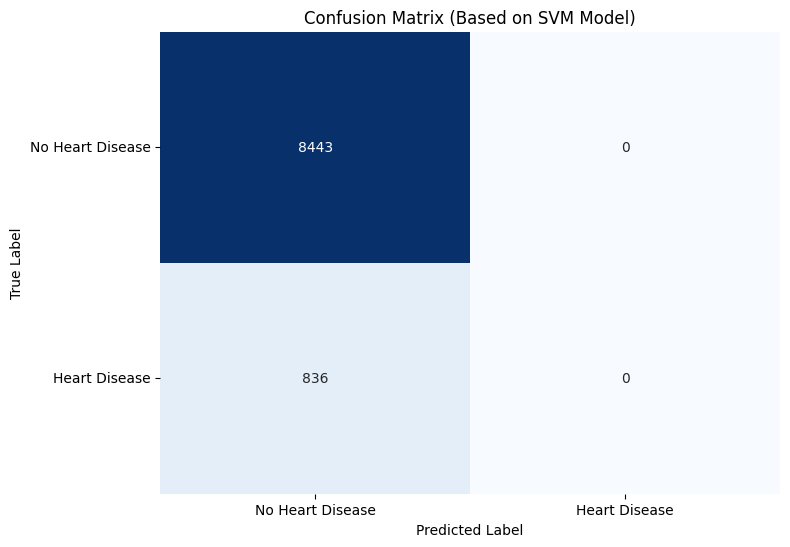

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the target values based on the best estimator found by GridSearchCV
y_test_pred = svm_grid_search.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Based on SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'], rotation=0)
plt.show()

In [32]:
import numpy as np

# Confusion matrix values
TN = 4116
FP = 0
FN = 510
TP = 0

# Calculate the total number of predictions
total_predictions = np.sum([TN, FP, FN, TP])

# Calculate the percentages using numpy for consistency
TP_percentage = np.round((TP / total_predictions) * 100, 2)
TN_percentage = np.round((TN / total_predictions) * 100, 2)
FP_percentage = np.round((FP / total_predictions) * 100, 2)
FN_percentage = np.round((FN / total_predictions) * 100, 2)

# Print the results
print(f"True Positives Percentage: {TP_percentage}%")
print(f"True Negatives Percentage: {TN_percentage}%")
print(f"False Positives Percentage: {FP_percentage}%")
print(f"False Negatives Percentage: {FN_percentage}%")

True Positives Percentage: 0.0%
True Negatives Percentage: 88.98%
False Positives Percentage: 0.0%
False Negatives Percentage: 11.02%
